# Imports

In [4]:
# Standard Libraries
import os
import io
import math
import time
import random
import tempfile
import warnings
from multiprocessing import Manager
from typing import Optional

# Third-party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import SimpleITK as sitk
import torch
import torch.nn as nn
import torchio as tio
from torch.utils.data import DataLoader, Dataset, random_split
from torch.cuda.amp import GradScaler, autocast

# MONAI Libraries
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism

# Custom Libraries
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler
from dataloader import Train ,Eval 

# Configuration
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")
warnings.filterwarnings('ignore')


JUPYTER_ALLOW_INSECURE_WRITES=True

# Set seeds and configs

In [5]:
# Initialize Configuration
config = {
    'batch_size': 1,
    'imgDimResize': (160, 192, 160),
    'imgDimPad': (208, 256, 208),
    'spatialDims': '3D',
    'unisotropic_sampling': True,
    'perc_low': 1,
    'perc_high': 99,
    'rescaleFactor': 2,
    'base_path': '/scratch1/akrami/Latest_Data/Data',
}

# Seed and Device Configuration
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CUDA and CUDNN Configuration
# Uncomment the following line to specify CUDA_VISIBLE_DEVICES
# os.environ['CUDA_VISIBLE_DEVICES'] = '2,3,5,6'
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# SimpleITK Configuration
# Set the default number of threads and global behavior for SimpleITK
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")



True

# Load the data

In [7]:
imgpath = {}
csvpath_trains=['/acmenas/hakrami/3D_lesion_DF/Data/splits/combined_4datasets.csv']
pathBase = '/acmenas/hakrami/patched-Diffusion-Models-UAD/Data_train'
csvpath_val = '/acmenas/hakrami/3D_lesion_DF/Data/splits/IXI_val_fold0.csv'
csvpath_test = '/acmenas/hakrami/3D_lesion_DF/Data/splits/IXI_test.csv'
var_csv = {}
states = ['train','val','test']

df_list = []

# Loop through each CSV file path and read it into a DataFrame
for csvpath in csvpath_trains:
    df = pd.read_csv(csvpath)
    df_list.append(df)

# %%
var_csv['train'] =pd.concat(df_list, ignore_index=True)
var_csv['val'] = pd.read_csv(csvpath_val)
var_csv['test'] = pd.read_csv(csvpath_test)
# if cfg.mode == 't2':
#     keep_t2 = pd.read_csv(cfg.path.IXI.keep_t2) # only keep t2 images that have a t1 counterpart

for state in states:
    var_csv[state]['settype'] = state
    var_csv[state]['norm_path'] =''
    var_csv[state]['img_path'] = pathBase  + var_csv[state]['img_path']
    var_csv[state]['mask_path'] = pathBase  + var_csv[state]['mask_path']
    var_csv[state]['seg_path'] =  var_csv[state]['mask_path']


data_train = Train(var_csv['train'],config) 
data_val = Train(var_csv['val'],config)                
data_test = Eval(var_csv['test'],config)



#data_train = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_train_fold0.csv', converters={'img_path': pd.eval}), config)
#train_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_val = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_val_fold0.csv', converters={'img_path': pd.eval}), config)
val_loader = DataLoader(data_val, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_test = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/Brats21_test.csv', converters={'img_path': pd.eval}), config)
test_loader = DataLoader(data_test, batch_size=config.get('batch_size', 1),shuffle=False,num_workers=8)


device = torch.device("cuda")

# Load the model

In [8]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[32, 64, 64],
    attention_levels=[False, False,True],
    num_head_channels=[0, 0,32],
    num_res_blocks=2,
)
model.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)

inferer = DiffusionInferer(scheduler)

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)

Using 8 GPUs!


In [9]:
# specify your model filename
#model_filename = '/scratch1/akrami/models/3Ddiffusion/half/model_epoch984.pt'
model_filename ='/acmenas/hakrami/3D_lesion_DF/models/small_net/model_large_epoch999.pt'
# load state_dict into the model
model.load_state_dict(torch.load(model_filename))

# if you need to set the model in evaluation mode
model.eval()

DataParallel(
  (module): DiffusionModelUNet(
    (conv_in): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
 

# Generate an Image

In [10]:
sub_test = next(iter(test_loader))
print(sub_test.keys())
print(sub_test['age'])
# Expand the dimensions of sub_test['peak'] to make it [1, 1, 1, 1, 4]
peak_expanded = (sub_test['peak'].unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)).long()
# Move both tensors to the device
image_array = sub_test['vol']['data'].to(device)
peak_expanded = peak_expanded.to(device)
image_array = (image_array / peak_expanded)
middle_slice_idx = image_array.size(-1) // 2

dict_keys(['vol', 'peak', 'seg', 'age', 'ID', 'path', 'mask'])
tensor([38.9000], dtype=torch.float64)


In [11]:
image = torch.randn_like(image_array)[:,:,:,:,:]
image = image.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
with autocast(enabled=True):
    image = inferer.sample_batch(input_noise=image, diffusion_model=model, scheduler=scheduler)

100%|██████████| 1000/1000 [02:24<00:00,  6.91it/s]


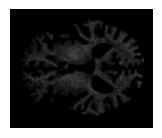

In [12]:
middle_slice_idx = image.size(-1) // 2
plt.figure(figsize=(2, 2))
plt.imshow(image[0, 0, :, :, middle_slice_idx].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

In [13]:
image = torch.randn_like(image_array)[0:1,0:1,:,:,:]
image = image.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
print(image.shape)
with autocast(enabled=True):
    image = inferer.sample(input_noise=image, diffusion_model=model, scheduler=scheduler)

torch.Size([1, 1, 80, 96, 80])


100%|██████████| 1000/1000 [02:18<00:00,  7.23it/s]


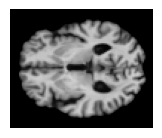

In [14]:
middle_slice_idx = image.size(-1) // 2
plt.figure(figsize=(2, 2))
plt.imshow(image[0, 0, :, :, middle_slice_idx].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

# Denoise test samples

In [15]:
def denoise(noised_img,sample_time,scheduler,inferer,model):
    with torch.no_grad():
        with autocast(enabled=True):
            for t in range(sample_time - 1, -1, -1):
                batch_size = noised_img.size(0)  # Get the batch size
                t_batch=torch.Tensor((t,)).to(noised_img.device)
                t_batch = t_batch.unsqueeze(0).expand(batch_size, -1)  # Expand tensor `t` to have the desired batch size
                t_batch = t_batch.to(noised_img.device)[:,0] 
                model_output = model(noised_img, timesteps=t_batch)
                noised_img, _ = scheduler.step(model_output, t, noised_img)
            return noised_img

    

In [16]:
def denoise_v1(image_array,sample_time,scheduler,inferer,model):
    noise =torch.randn_like(image_array)
    noisy_img = scheduler.add_noise(original_samples=image_array, noise=noise, timesteps=torch.tensor(sample_time))
    noised_img = noisy_img.to(device)

    scheduler.set_timesteps(num_inference_steps=sample_time)
    with autocast(enabled=True):
        denoised_sample = inferer.sample(input_noise=noised_img, diffusion_model=model, scheduler=scheduler)
    return denoised_sample

In [17]:
print(image.shape)
print(image_array.shape)

torch.Size([1, 1, 80, 96, 80])
torch.Size([1, 1, 80, 96, 80])


100%|██████████| 999/999 [02:18<00:00,  7.23it/s]


Text(0.5, 1.0, 'org Image')

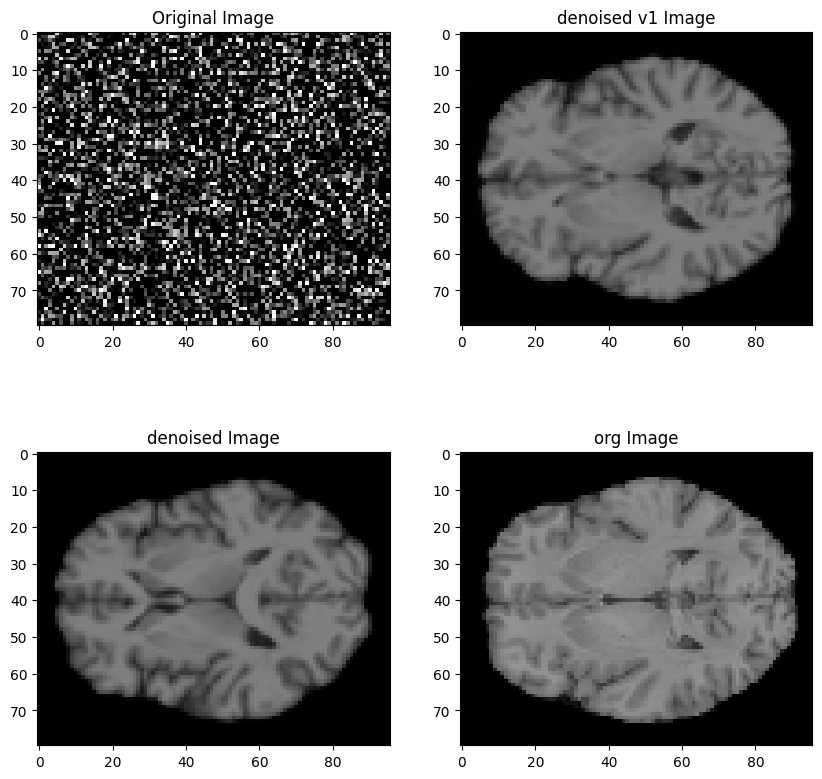

In [18]:
i = 0
sample_time = 999
noise =torch.randn_like(image_array)
noisy_img = scheduler.add_noise(original_samples=image_array, noise=noise, timesteps=torch.tensor(sample_time))
noised_img = noisy_img.to(device)
middle_slice_idx = image_array.size(-1) // 2
    
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Original Image
axes[0, 0].imshow(noised_img[i][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[0, 0].set_title('Original Image')
#recon_img = denoise(image_array.to(device),sample_time,scheduler,inferer,model)

denoised_sample = denoise(noisy_img,sample_time,scheduler,inferer,model)
# Original Image
axes[1, 0].imshow(denoised_sample[i][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[1, 0].set_title('denoised Image')

denoised_sample = denoise_v1(image_array[i:i+1][:][:,:,:],sample_time,scheduler,inferer,model)
# Original Image
axes[0, 1].imshow(denoised_sample[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[0, 1].set_title('denoised v1 Image')


axes[1, 1].imshow(image_array[i][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[1, 1].set_title('org Image')

In [19]:
import torch

# Example tensor of shape (batch_size, channels, height, width, depth)
image_tensor = image_array[0:1,:,:,:,:]+0

# Coordinates for the patch you want to remove
start_h, start_w, start_d = 30, 30, 30
end_h, end_w, end_d = 50, 50, 50

# Create a mask of ones
mask = torch.ones_like(image_tensor)

# Set the patch area in the mask to zeros
mask[:, :, start_h:end_h, start_w:end_w, start_d:end_d] = 0

# "Remove" the patch from the image by setting it to zeros (or any other value)
image_tensor[:, :, start_h:end_h, start_w:end_w, start_d:end_d] = 0


model.eval()
mask = mask.to(device)
# val_image_masked = val_image_masked.to(device)
# timesteps = torch.Tensor((999,)).to(noise.device).long()
# val_image_inpainted = torch.randn((1, 1, 64, 64)).to(device)

# scheduler.set_timesteps(num_inference_steps=1000)
# progress_bar = tqdm(scheduler.timesteps)

# num_resample_steps = 4

import tqdm as tqdm
mask = mask.to(device)
val_image_masked = image_tensor.to(device)
val_image_inpainted = torch.randn_like(val_image_masked).to(device)
timesteps = torch.Tensor((999,)).to(noise.device).long()
scheduler.set_timesteps(num_inference_steps=999)
progress_bar = tqdm.tqdm(scheduler.timesteps)

num_resample_steps = 4
with torch.no_grad():
    with autocast(enabled=True):
        for t in progress_bar:
            for u in range(num_resample_steps):
                # get the known portion at t-1
                if t > 0:
                    noise =  torch.randn_like(val_image_masked).to(device)
                    timesteps_prev = torch.Tensor((t - 1,)).to(device).long()
                    val_image_inpainted_prev_known = scheduler.add_noise(
                        original_samples=val_image_masked, noise=noise, timesteps=timesteps_prev
                    )
                else:
                    val_image_inpainted_prev_known = val_image_masked
                
                # perform a denoising step to get the unknown portion at t-1
                if t > 0:
                    timesteps = torch.Tensor((t,)).to(device).long()
                    model_output = model(val_image_inpainted, timesteps=timesteps)
                    val_image_inpainted_prev_unknown, _ = scheduler.step(model_output, t, val_image_inpainted)

                # combine known and unknown using the mask
                val_image_inpainted = torch.where(
                    mask == 1, val_image_inpainted_prev_known, val_image_inpainted_prev_unknown
                )

                # perform resampling
                if t > 0 and u < (num_resample_steps - 1):
                    # sample x_t from x_t-1
                    noise = torch.randn_like(val_image_masked).to(device)
                    val_image_inpainted = (
                        torch.sqrt(1 - scheduler.betas[t - 1]) * val_image_inpainted
                        + torch.sqrt(scheduler.betas[t - 1]) * noise
                    )



  0%|          | 0/999 [00:00<?, ?it/s]

100%|██████████| 999/999 [09:26<00:00,  1.76it/s]


Text(0.5, 1.0, 'denoised Image ')

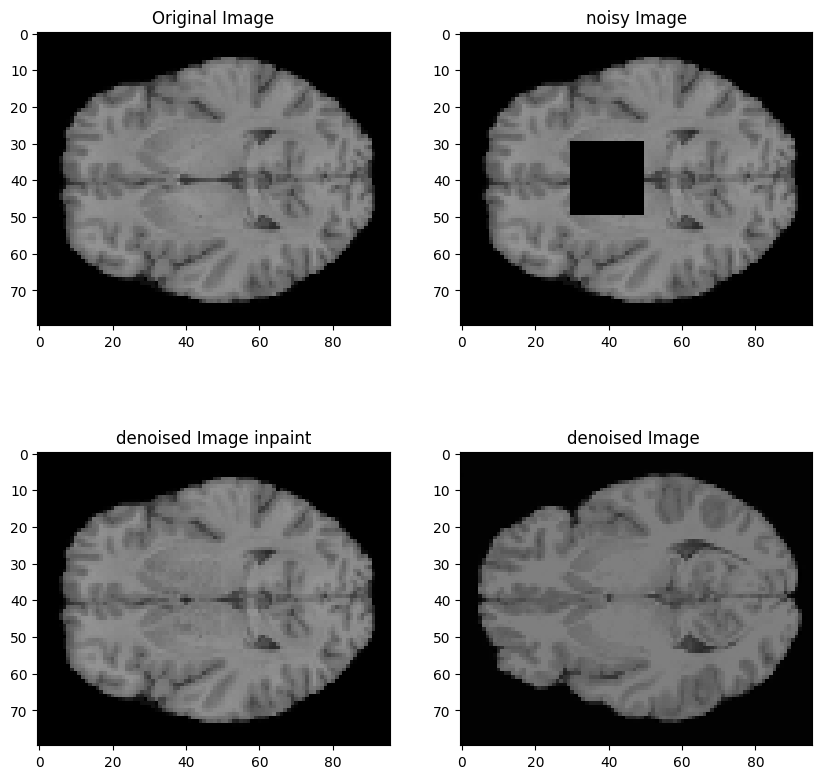

In [20]:
sample_time =999
# Original Image
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(image_array[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[0, 0].set_title('Original Image')
#recon_img = denoise(image_array.to(device),sample_time,scheduler,inferer,model)
# Original Image
axes[0, 1].imshow(image_tensor[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[0, 1].set_title('noisy Image')
#recon_img = denoise(image_array.to(device),sample_time,scheduler,inferer,model)
# Original Image
axes[1, 0].imshow(val_image_inpainted[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[1, 0].set_title('denoised Image inpaint')


noise =torch.randn_like(image_tensor)
noisy_img = scheduler.add_noise(original_samples=image_tensor, noise=noise, timesteps=torch.tensor(sample_time))
noised_img = noisy_img.to(device)
denoised_sample = denoise(noisy_img,sample_time,scheduler,inferer,model)
axes[1, 1].imshow(denoised_sample[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[1, 1].set_title('denoised Image ')

In [17]:
image_array_1= image_tensor[0:1,:,:,:,:]+0
mask = torch.rand_like(image_array_1).to(device)
mask[mask<=0.7] = 0
mask[mask>0.7] = 1


val_image_masked = image_array_1.to(device)*mask
val_image_inpainted = torch.randn_like(image_array_1).to(device) 
# plot
mask_2 =1- (mask.to(device))
val_image_masked_2 = image_array_1.to(device)*mask_2
val_image_inpainted_2 = torch.randn_like(image_array_1).to(device)

scheduler.set_timesteps(num_inference_steps=999)
progress_bar = tqdm.tqdm(scheduler.timesteps)

num_resample_steps = 4
with torch.no_grad():
    with autocast(enabled=True):
        for t in progress_bar:
            for u in range(num_resample_steps):
                # get the known portion at t-1
                if t > 0:
                    noise =  torch.randn_like(image_array_1).to(device)
                    timesteps_prev = torch.Tensor((t - 1,)).to(device).long()
                    val_image_inpainted_prev_known = scheduler.add_noise(
                        original_samples=val_image_masked, noise=noise, timesteps=timesteps_prev
                    )
                else:
                    val_image_inpainted_prev_known = val_image_masked

                # perform a denoising step to get the unknown portion at t-1
                if t > 0:
                    timesteps = torch.Tensor((t,)).to(device).long()
                    model_output = model(val_image_inpainted, timesteps=timesteps)
                    val_image_inpainted_prev_unknown, _ = scheduler.step(model_output, t, val_image_inpainted)

                # combine known and unknown using the mask
                val_image_inpainted = torch.where(
                    mask == 1, val_image_inpainted_prev_known, val_image_inpainted_prev_unknown
                )




# num_resample_steps = 4
# with torch.no_grad():
#     with autocast(enabled=True):
#         for t in progress_bar:
#             for u in range(num_resample_steps):
#                 # get the known portion at t-1
#                 if t > 0:
#                     noise =  torch.randn_like(image_array_1).to(device)
#                     timesteps_prev = torch.Tensor((t - 1,)).to(device).long()
#                     val_image_inpainted_prev_known = scheduler.add_noise(
#                         original_samples=val_image_masked_2, noise=noise, timesteps=timesteps_prev
#                     )
#                 else:
#                     val_image_inpainted_prev_known = val_image_masked_2

#                 # perform a denoising step to get the unknown portion at t-1
#                 if t > 0:
#                     timesteps = torch.Tensor((t,)).to(device).long()
#                     model_output = model(val_image_inpainted_2, timesteps=timesteps)
#                     val_image_inpainted_prev_unknown, _ = scheduler.step(model_output, t, val_image_inpainted_2)

#                 # combine known and unknown using the mask
#                 val_image_inpainted_2 = torch.where(
#                     mask_2 == 1, val_image_inpainted_prev_known, val_image_inpainted_prev_unknown
#                 )



100%|██████████| 999/999 [04:29<00:00,  3.71it/s]


In [ ]:
image_array_1= image_tensor[0:1,:,:,:,:]+0
mask = torch.rand_like(image_array_1).to(device)
mask[mask<=0.7] = 0
mask[mask>0.7] = 1


val_image_masked = image_array_1.to(device)*mask
val_image_inpainted = torch.randn_like(image_array_1).to(device) 
# plot
mask_2 =1- (mask.to(device))
val_image_masked_2 = image_array_1.to(device)*mask_2
val_image_inpainted_2 = torch.randn_like(image_array_1).to(device)

scheduler.set_timesteps(num_inference_steps=999)
progress_bar = tqdm.tqdm(scheduler.timesteps)

num_resample_steps = 4
with torch.no_grad():
    with autocast(enabled=True):
        for t in progress_bar:
            for u in range(num_resample_steps):
                # get the known portion at t-1
                if t > 0:
                    noise =  torch.randn_like(image_array_1).to(device)
                    timesteps_prev = torch.Tensor((t - 1,)).to(device).long()
                    val_image_inpainted_prev_known = scheduler.add_noise(
                        original_samples=val_image_masked, noise=noise, timesteps=timesteps_prev
                    )
                else:
                    val_image_inpainted_prev_known = val_image_masked

                # perform a denoising step to get the unknown portion at t-1
                if t > 0:
                    timesteps = torch.Tensor((t,)).to(device).long()
                    model_output = model(val_image_inpainted, timesteps=timesteps)
                    val_image_inpainted_prev_unknown, _ = scheduler.step(model_output, t, val_image_inpainted)

                # combine known and unknown using the mask
                val_image_inpainted = torch.where(
                    mask == 1, val_image_inpainted_prev_known, val_image_inpainted_prev_unknown
                )




# num_resample_steps = 4
# with torch.no_grad():
#     with autocast(enabled=True):
#         for t in progress_bar:
#             for u in range(num_resample_steps):
#                 # get the known portion at t-1
#                 if t > 0:
#                     noise =  torch.randn_like(image_array_1).to(device)
#                     timesteps_prev = torch.Tensor((t - 1,)).to(device).long()
#                     val_image_inpainted_prev_known = scheduler.add_noise(
#                         original_samples=val_image_masked_2, noise=noise, timesteps=timesteps_prev
#                     )
#                 else:
#                     val_image_inpainted_prev_known = val_image_masked_2

#                 # perform a denoising step to get the unknown portion at t-1
#                 if t > 0:
#                     timesteps = torch.Tensor((t,)).to(device).long()
#                     model_output = model(val_image_inpainted_2, timesteps=timesteps)
#                     val_image_inpainted_prev_unknown, _ = scheduler.step(model_output, t, val_image_inpainted_2)

#                 # combine known and unknown using the mask
#                 val_image_inpainted_2 = torch.where(
#                     mask_2 == 1, val_image_inpainted_prev_known, val_image_inpainted_prev_unknown
#                 )



Text(0.5, 1.0, 'masked_visited')

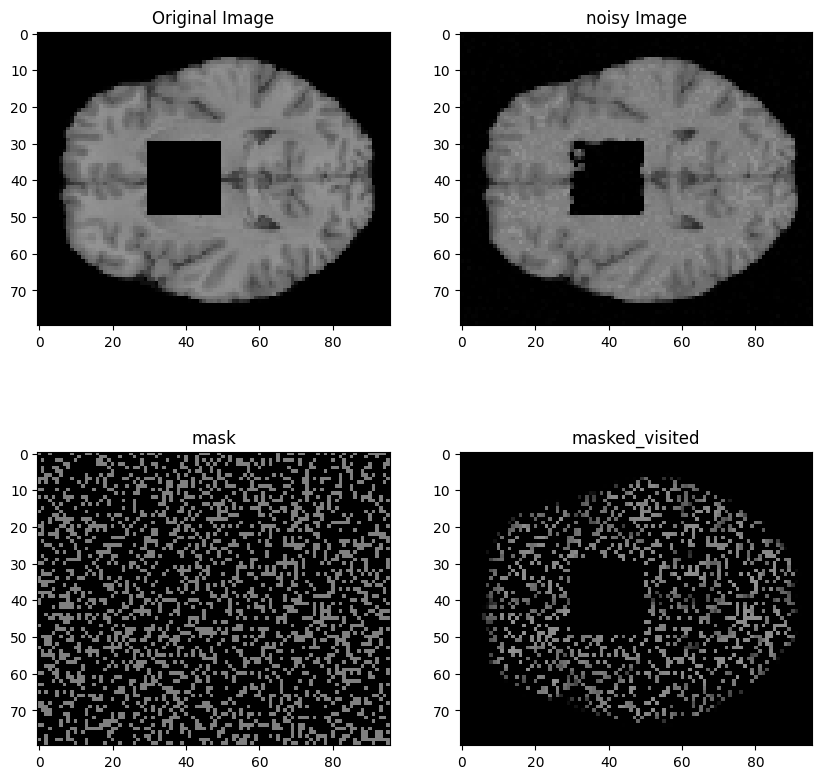

In [18]:
sample_time =999
# Original Image
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(image_array_1[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[0, 0].set_title('Original Image')
#recon_img = denoise(image_array.to(device),sample_time,scheduler,inferer,model)
# Original Image
axes[0, 1].imshow(val_image_inpainted[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[0, 1].set_title('noisy Image')
#recon_img = denoise(image_array.to(device),sample_time,scheduler,inferer,model)
# Original Image
axes[1, 0].imshow(mask[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[1, 0].set_title('mask')
axes[1, 1].imshow(val_image_masked[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[1, 1].set_title('masked_visited')




In [19]:
from generative.networks.nets import DiffusionModelUNet_2Q

model = DiffusionModelUNet_2Q(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[32, 64, 128, 128],
    attention_levels=[False, False, False,True],
    num_head_channels=[0, 0, 0,32],
    num_res_blocks=2,
)

model.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)


scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)
inferer = DiffusionInferer(scheduler)
optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)
scaler = GradScaler()


Using 2 GPUs!


In [20]:
# specify your model filename
model_filename ='/project/ajoshi_27/akrami/3D_lesion_DF/models/3Q/model_25_epoch499.pt'
model.load_state_dict(torch.load(model_filename))
model.eval()

DataParallel(
  (module): DiffusionModelUNet_2Q(
    (conv_in): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
    

In [21]:
noise = torch.randn_like(image_tensor).to(device)
timesteps = torch.randint(299, 300, (image_tensor.shape[0],), device=image_tensor.device).long()
prediction,prediction_m,prediction_h = inferer(inputs=image_tensor, diffusion_model=model, noise=noise, timesteps=timesteps)

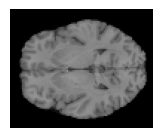

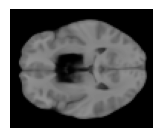

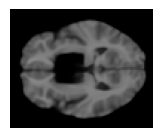

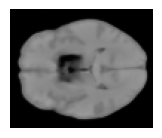

In [23]:

i=0
plt.figure(figsize=(2, 2))
plt.imshow(image_array[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

plt.figure(figsize=(2, 2))
plt.imshow(prediction_m[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()


plt.figure(figsize=(2, 2))
plt.imshow(prediction[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

plt.figure(figsize=(2, 2))
plt.imshow(prediction_h[i, 0, :, :, middle_slice_idx].detach().cpu().numpy(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

        